In [55]:
import os

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from tqdm import tqdm

from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset


# Set the device to Apple MPS.
mps_device = torch.device("mps")

## Load the dataset

In [ ]:
root = "."

train_dataset = SimpleOxfordPetDataset(root, "train")
valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(root, "test")

# It is a good practice to check datasets don`t intersects with each other
assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 3312
Valid size: 368
Test size: 3669


In [52]:
n_cpu = os.cpu_count()
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True, 
    num_workers=n_cpu,
)
valid_dataloader = DataLoader(
    valid_dataset, 
    batch_size=16, 
    shuffle=False, 
    num_workers=n_cpu,
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=16, 
    shuffle=False, 
    num_workers=n_cpu,
)

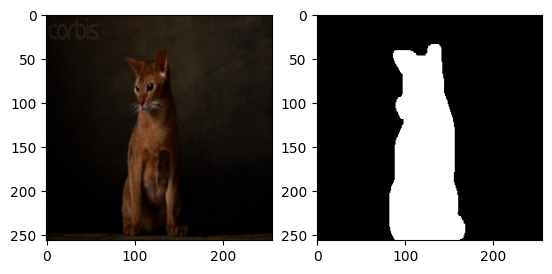

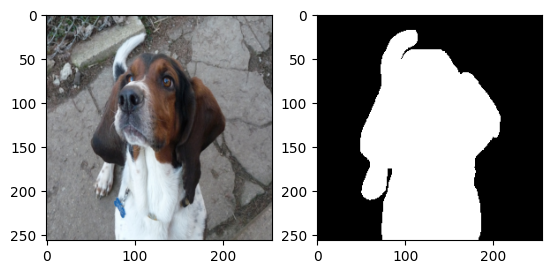

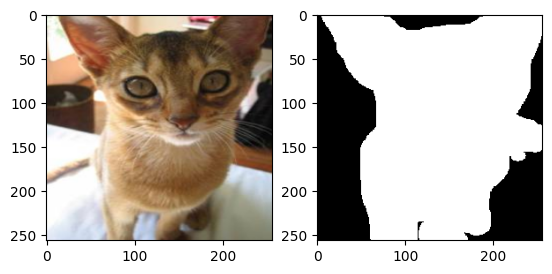

In [53]:
def getImage(dataset, idx):
    sample = dataset[idx]
    plt.subplot(1, 2, 1)
    plt.imshow(sample["image"].transpose(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(sample["mask"].squeeze(), cmap="gray")
    plt.show()

getImage(train_dataset, 13)
getImage(valid_dataset, 16)
getImage(test_dataset, 19)

## Model

In [56]:
class SegmentationModel(nn.Module):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch=arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        params = smp.encoders.get_preprocessing_params(encoder_name)

        self.std = torch.tensor(params["std"], device=mps_device).view(1, 3, 1, 1)
        self.mean = torch.tensor(params["mean"], device=mps_device).view(1, 3, 1, 1)

        self.loss_fn = smp.losses.DiceLoss(
            mode="binary",
            from_logits=True,
        )
    
    def forward(self, im):
        im = (im - self.mean) / self.std
        return self.model(im)

In [58]:
def train(model, data_loader, optimizer, criterion):
    model.train()
    model.to(mps_device)

    total_loss = 0.0

    with tqdm(total=len(data_loader), desc="Model Training") as progress:
        for batch in data_loader:
            images = batch["image"]
            images = images.to(mps_device)
            masks = batch["mask"]
            masks = masks.to(mps_device)

            optimizer.zero_grad()
            logits_mask = model(images)
            loss = criterion(logits_mask, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress.update(1)
        
    return total_loss / len(data_loader)

def validate(model, data_loader, criterion):
    model.eval()
    model.to(mps_device)

    total_loss = 0.0

    with torch.no_grad(), tqdm(total=len(data_loader), desc="Model Validation") as progress:
        for batch in data_loader:
            images = batch["image"]
            images = images.to(mps_device)
            masks = batch["mask"]
            masks = masks.to(mps_device)

            logits_mask = model(images)
            loss = criterion(logits_mask, masks)

            total_loss += loss.item()
            progress.update(1)

    return total_loss / len(data_loader)

def test(model, data_loader):
    model.eval()
    model.to(mps_device)

    total_loss = 0.0

    with torch.no_grad(), tqdm(total=len(data_loader), desc="Model Testing") as progress:
        for batch in data_loader:
            images = batch["image"]
            images = images.to(mps_device)
            masks = batch["mask"]
            masks = masks.to(mps_device)

            logits_mask = model(images)
            loss = model.loss_fn(logits_mask, masks)

            total_loss += loss.item()
            progress.update(1)

    return total_loss / len(data_loader)


model = SegmentationModel(
    arch="FPN",
    encoder_name="resnet34",
    in_channels=3,
    out_classes=1,
)
model.to(mps_device)

criterion = smp.losses.DiceLoss(
    mode="binary",
    from_logits=True,
)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/ashrock_m13/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100.0%


In [59]:
epochs = 10
train_losses = []
valid_losses = []

for epoch in range(epochs):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    valid_loss = validate(model, valid_dataloader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}")

test_loss = test(model, test_dataloader)
print(f"Test Loss: {test_loss:.4f}")

Model Validation: 100%|██████████| 23/23 [01:06<00:00,  2.91s/it]


Epoch 1/10
Train Loss: 0.0966
Valid Loss: 0.0577


Model Validation: 100%|██████████| 23/23 [01:06<00:00,  2.90s/it]


Epoch 2/10
Train Loss: 0.0520
Valid Loss: 0.0521


Model Validation: 100%|██████████| 23/23 [01:06<00:00,  2.88s/it]


Epoch 3/10
Train Loss: 0.0437
Valid Loss: 0.0505


Model Validation: 100%|██████████| 23/23 [01:10<00:00,  3.05s/it]


Epoch 4/10
Train Loss: 0.0387
Valid Loss: 0.0473


Model Validation: 100%|██████████| 23/23 [01:06<00:00,  2.90s/it]


Epoch 5/10
Train Loss: 0.0372
Valid Loss: 0.0500


Model Validation: 100%|██████████| 23/23 [01:06<00:00,  2.90s/it]


Epoch 6/10
Train Loss: 0.0331
Valid Loss: 0.0464


Model Validation: 100%|██████████| 23/23 [01:06<00:00,  2.90s/it]


Epoch 7/10
Train Loss: 0.0301
Valid Loss: 0.0472


Model Validation: 100%|██████████| 23/23 [01:07<00:00,  2.95s/it]


Epoch 8/10
Train Loss: 0.0283
Valid Loss: 0.0476


Model Validation: 100%|██████████| 23/23 [01:08<00:00,  2.96s/it]


Epoch 9/10
Train Loss: 0.0275
Valid Loss: 0.0532


Model Validation: 100%|██████████| 23/23 [01:06<00:00,  2.91s/it]


Epoch 10/10
Train Loss: 0.0292
Valid Loss: 0.0497


Model Testing: 100%|██████████| 230/230 [01:22<00:00,  2.78it/s]

Test Loss: 0.0464


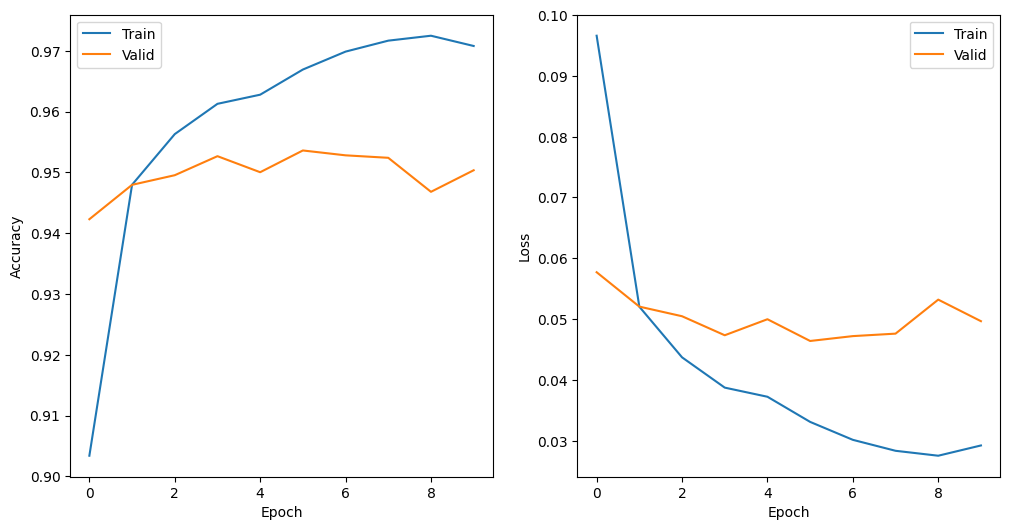

In [62]:
train_accuracy = [1 - loss for loss in train_losses]
valid_accuracy = [1 - loss for loss in valid_losses]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label="Train")
plt.plot(valid_accuracy, label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


In [63]:
# Overall Accuracy

print(f"Overall Accuracy: {1 - test_loss:.4f}")

Overall Accuracy: 0.9536


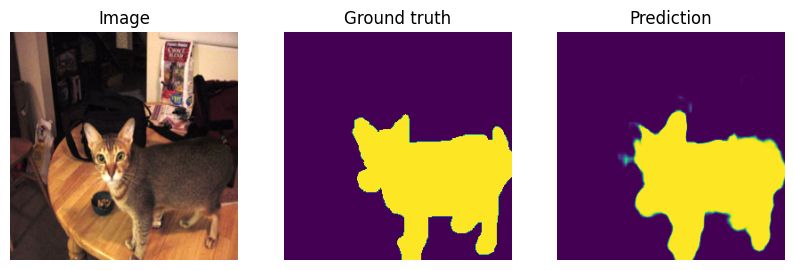

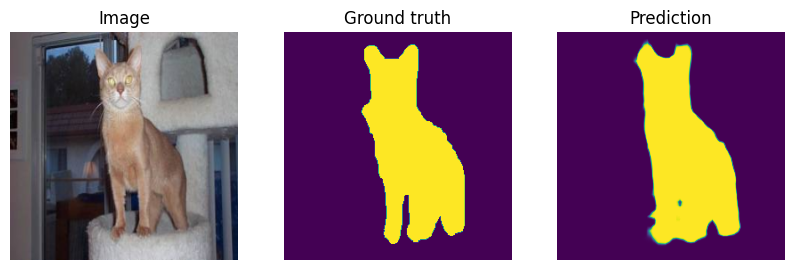

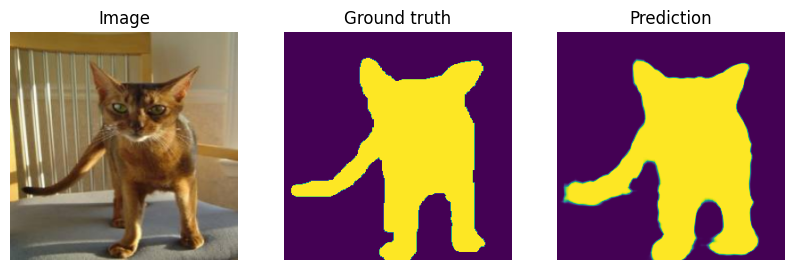

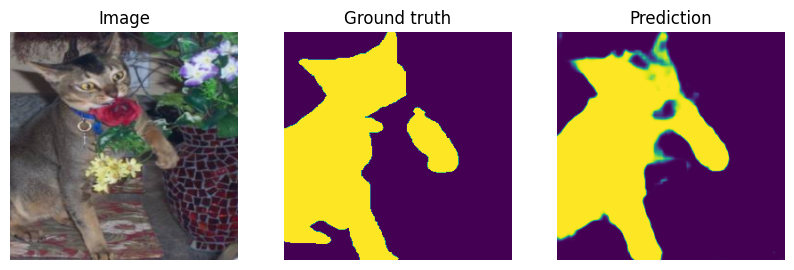

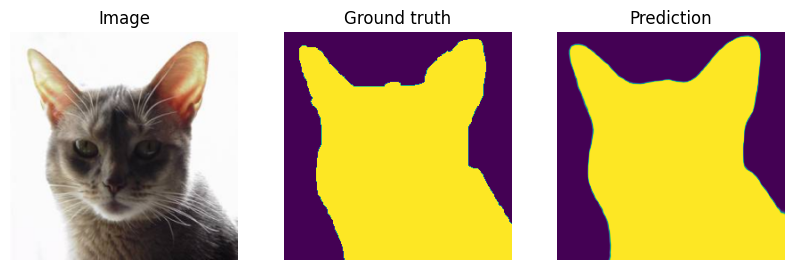

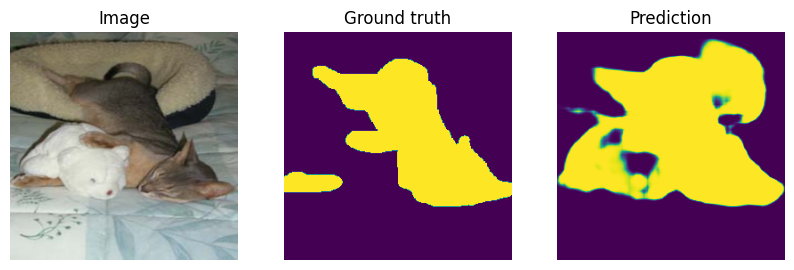

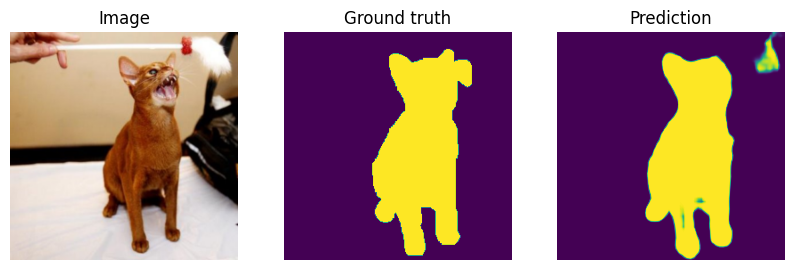

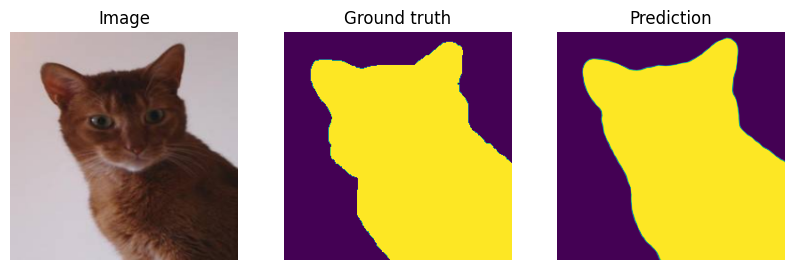

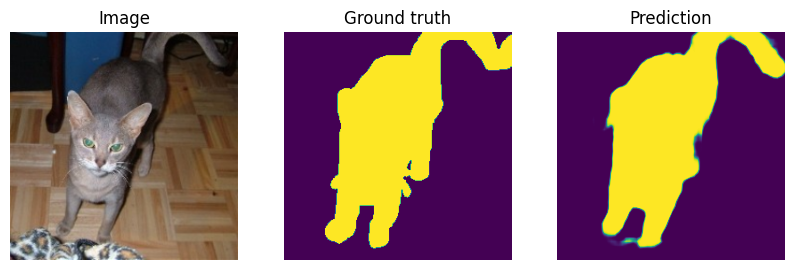

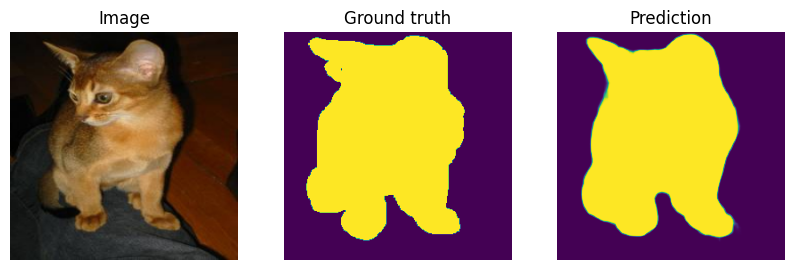

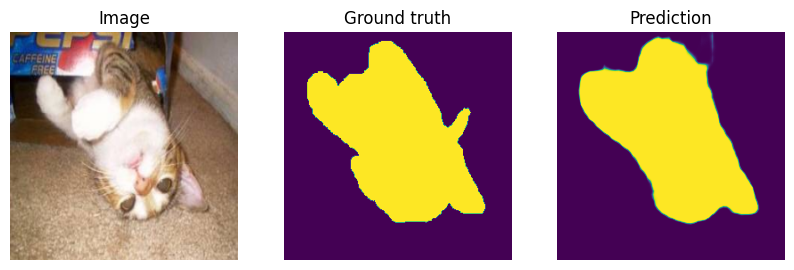

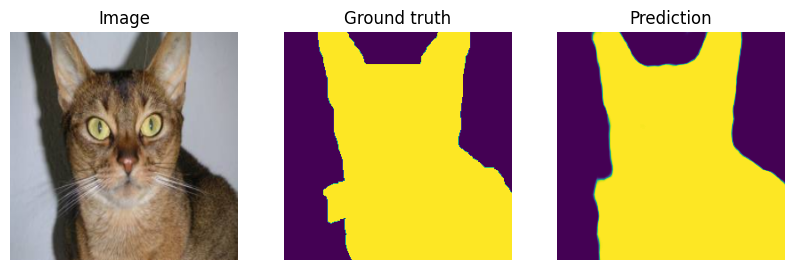

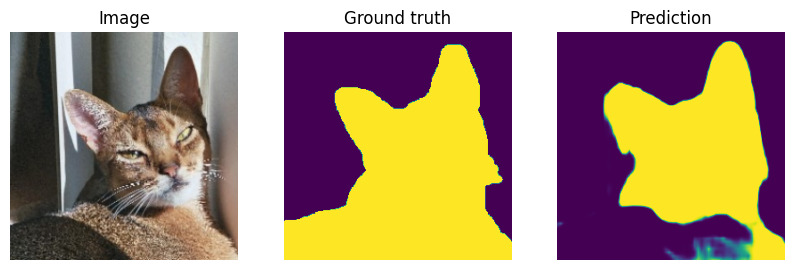

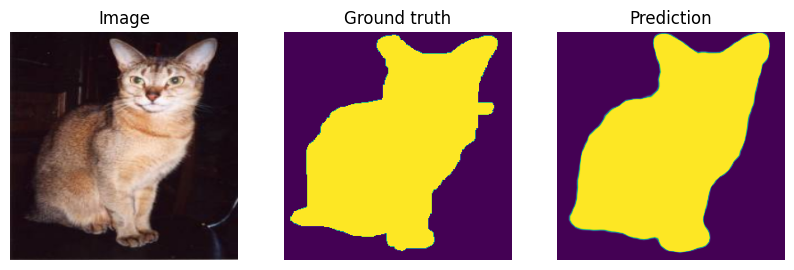

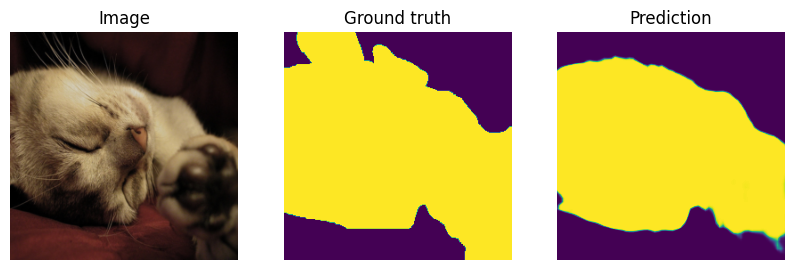

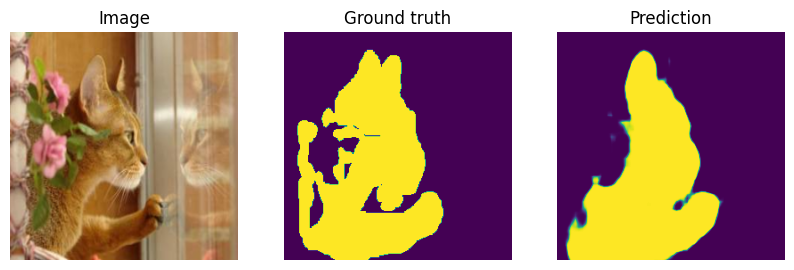

In [64]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"].to(mps_device))
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.cpu().numpy().squeeze())
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [66]:
torch.save(model, 'model/model.pth')